## Goals

To complete this section, there needs to be code that:

Pads any tiles smaller tiles with NaN values to make it equivalent in size

Divides up an image into tiles through subsetting.

Stores the order of those images.

Stitches those tiles back together.

In [7]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import math
with rio.open('/Users/jsnakata/Desktop/School/CHEM E 599/Image Data/TuolumneMeadowsSubset.tif') as img :
    imgnp= img.read()
    
imgnp = imgnp.squeeze()
plt.imshow(imgnp, cmap='gray')
plt.axis('off')

(-0.5, 4999.5, 4999.5, -0.5)

In [8]:
np.shape(imgnp)

(5000, 5000)

Shown below is how I tested taking slices of larger images for my tiling function. I needed to determine what values control vertical, which control horizontal, and also see what would be the best way to slice the tile. I settled on reusing one line of pixels for each adjacent image. This way tiles can be sliced [0:1000,0:1000] then [1000:2000, 1000:2000], instead of moving one pixel over and making slicing harder.

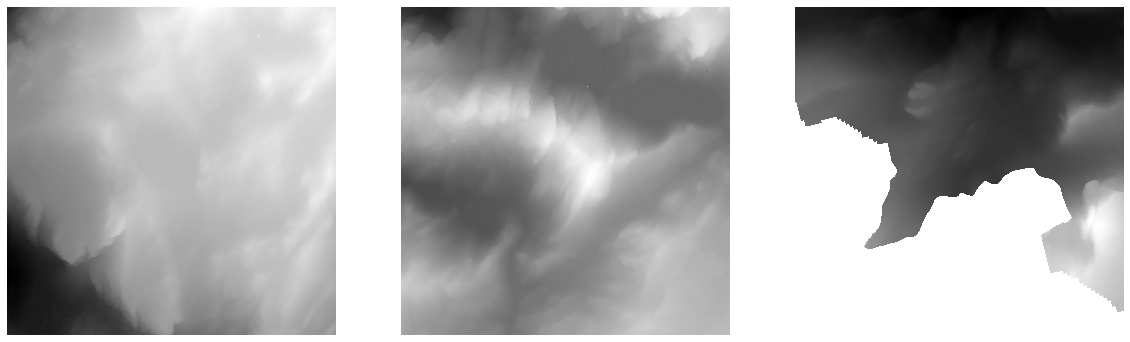

In [9]:
# Tiles of uniform size?
im_sub1 = imgnp[0:1000,0:1000] # first value controls vertical, second controls horizontal
im_sub2 = imgnp[1001:2001, 0:1000]
im_sub3 = imgnp[2500:3500, 0:1000]
fig, ax = plt.subplots(ncols=3, figsize=(20,20))

for axi in ax:
    axi.axis('off')
    
ax[0].imshow(im_sub1, cmap='gray')
ax[1].imshow(im_sub2, cmap='gray')
ax[2].imshow(im_sub3, cmap='gray')

**This markdown cell shows the planning stage of my universal_padding function.**

This function uses np.pad to pad any image with NaN values in any direction to make it a specific shape.
- Choose the tile size
- Create an array of NaN values of that size
- Replace the correct NaN values with pixel values

For a 500x500 image:

(0:500, 0) is the left edge

(0:500, 500) is the right edge

(0, 0:500) is the top edge

(500, 0:500) is the bottom edge

The cell below tests out the np.pad function with slices and plots it so I can compare a desired slice shape with a slice being modified.

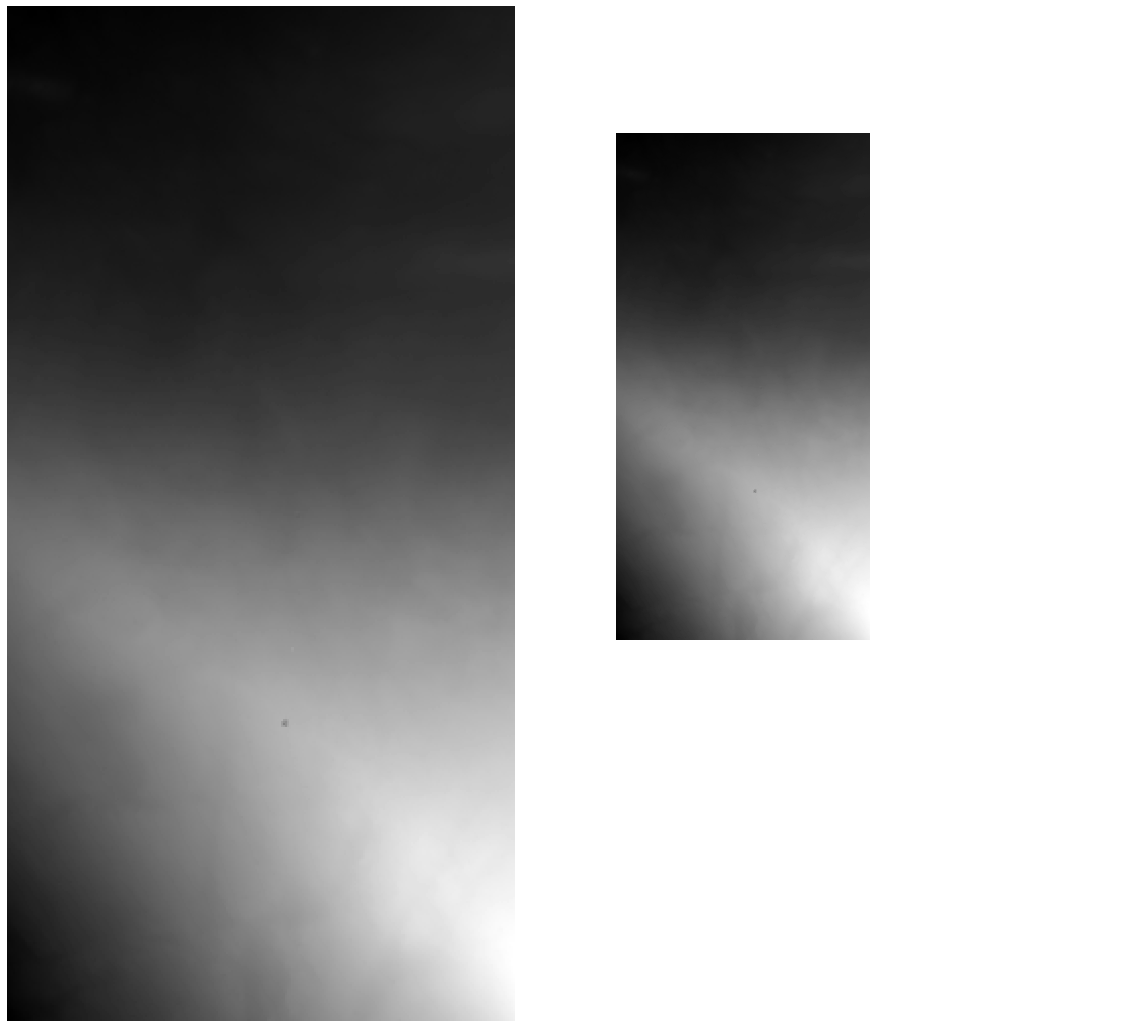

In [35]:
NaNarray = np.empty((500,500))
NaNarray[:] = np.nan
im_sub4 = imgnp[2750:3250, 4750:5000]
pad_sub4 = np.pad(im_sub4, ((0,250),(0,250)), 'constant', constant_values=np.nan) # pads to the right and 
# downwards with NaN
# How do I make this work no matter where in the image a slice is pulled?

fig, ax = plt.subplots(ncols=2, figsize=(20,20))

for axi in ax:
    axi.axis('off')
    
ax[0].imshow(im_sub4, cmap='gray')
ax[1].imshow(pad_sub4, cmap='gray')

In [11]:
np.shape(im_sub4)

(500, 250)

The following cells showcase me trying to figure out the best way to use different data types to slice and store information within a function. Image shapes were first considered to be stored in lists, but I settled on tuples because of their immutability.

In [12]:
size = np.shape(im_sub4) 
size_list = np.array(size)
des_size = np.array([500,500])
list_dif = np.zeros(len(size_list))
for i in range(len(size_list)):
    list_dif[i] = des_size[i] - size_list[i]
list_dif
    

array([  0., 250.])

In [13]:
test1 = np.array([500,500])
test2 = np.array([350,250])
test3 = tuple(test1-test2)
test1[1] += test2[0]
test1

array([500, 850])

In [14]:
def universal_padding(tile, shape, top, bottom, left, right):
    """Takes a subset from an image and pads specified edges with NaN values 
    to fit a standard array size. Requires True/False inputs for each edge, 
    as well as a desired array shape. The edges should only be adjacent, never opposite."""
    import numpy as np
    
    vert = np.array([0,0])
    horiz = np.array([0,0])
    
    tile_size = np.shape(tile) # Finds the shape of the tile
    t_array = np.array(tile_size) # Converts the shape from a tuple into an array
    
    pad_width = np.array(shape) - t_array # Should be a positive value
    
    if pad_width.all() < 0:
        print('The given tile is larger than the specified shape')
        return
    
    if bottom==True:
        vert[1] += pad_width[0]
    elif top==True:
        vert[0] += pad_width[0]
    
    if right==True:
        horiz[1] += pad_width[1]
    elif left==True:
        horiz[0] += pad_width[1]
            
    vert = tuple(vert)
    horiz = tuple(horiz)
    padded_tile = np.pad(tile, (vert, horiz), 'constant', constant_values=np.nan)
    
    return padded_tile

Above is the universal padding function, and below are different tests and demonstrations of the function's uses.

In [15]:
trythis = universal_padding(im_sub4, (500,500), False, True, False, True)

In [16]:
im_sub5 = imgnp[501:1001, 0:250]

howabout = universal_padding(im_sub5, (500,500), False, False, True, False)

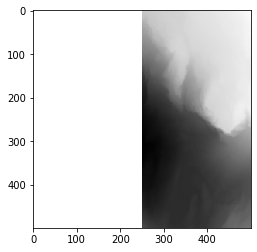

In [17]:
plt.imshow(howabout, cmap='gray')

Below is the planning stage as well as some other scratch work for the tile_slicer function. This function will take an image and divide it into multiple tiles of specified shape, storing them in a dictionary with keys as the location so that the image can be put back together. That function is still underway.

In [18]:
# Specifies tile shape
# Divides vertically and horizontally and rounds up to find number of tiles
# Function should iterate one direction (vert or horiz) while keeping the other one at constant location


div = np.shape(im_sub5) / np.array([100,100])

for i in range(len(div)):
    div[i] = math.ceil(div[i])
np.shape(im_sub5)

(500, 250)

It is a constant battle for me to try to work with different data types, so there are cells littered all over this notebook of me confirming how different data types work and interact.

In [19]:
# Scratch Work Cell
x = ([5,2], [6,7])
y = np.array(np.shape(x))
shuple = list(np.shape(im_sub5))
shuple

[500, 250]

In [36]:
def tile_slicer(im, shape):
    """Takes image and divides it into multiple tiles with equal specified shape.
    Shape should be a tuple with the desired tile size. Returns as a dicctionary with 
    tile locations as keys of data type tuple."""
    import numpy as np
    
    if type(shape) != tuple:
        print('The specified shape is not in tuple form.')
        return 
    
    im_shape = np.array(np.shape(im)) # the full shape of the image, tuple
    des_shape = np.array(shape)
    div = im_shape / des_shape
    for i in range(len(div)):
        div[i] = math.ceil(div[i])
    print(div)
    for i in div: # Ends the function if the tile size is greater than the image
        if i < 1:
            print('The specified tile size is larger than the image.')
            return
    tile_num = int(np.prod(div))
    #print(tile_num, 'Tiles')
    
    shape_iter = list(shape)
    
    tile_dict = {}
    for i in range(1,int(div[1])+1): # iterates with different tiles locations until the whole image is captured 
        for j in range(1,int(div[0])+1):
            location = tuple([i,j])
            # subset slicing
            # vertical coordinates
            vh = j * shape_iter[0]
            vl = vh - shape_iter[0]
            hh = i * shape_iter[1]
            hl = hh - shape_iter[1]
            #print(f'{vl}:{vh}')
            #print(f'{hl}:{hh}')
            subset = im[vl:vh, hl:hh]
            tile_dict[location] = subset
            
    return tile_dict
        

Above is the tile_slicer function that takes an input of an image and a specified shape smaller than the image as a tuple. It then returns a dictionary with tiles of the same size as the specified shape cut and organized from the larger image.


Below is the function being tests, as well as the dictionary being iterated in order to check to see if all tiles were the same size. They weren't. The next step is to integrate the universal_padding function to make them all uniform in size.

[10. 10.]


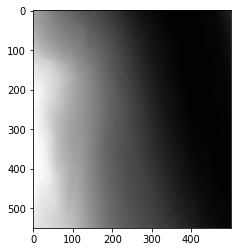

In [38]:
test = tile_slicer(imgnp, (550,500))
plt.imshow(test[(10,8)], cmap='gray')

In [34]:
# Iterating through the dictionary to check for tile size
for key in test.keys():
    print(np.shape(test[key]))

(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(50, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(50, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(50, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(50, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(50, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(50, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(50, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(50, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(550, 500)
(50, 500)
(550, 500)
(550, 50

In [152]:
empty_dict = {} 
for i in range(1,11):
    #print(i)
    for j in range(1,11):
        #print(j)
        location = tuple([i,j])
        #print(location)
        empty_dict[location] = None
print(empty_dict)

{(1, 1): None, (1, 2): None, (1, 3): None, (1, 4): None, (1, 5): None, (1, 6): None, (1, 7): None, (1, 8): None, (1, 9): None, (1, 10): None, (2, 1): None, (2, 2): None, (2, 3): None, (2, 4): None, (2, 5): None, (2, 6): None, (2, 7): None, (2, 8): None, (2, 9): None, (2, 10): None, (3, 1): None, (3, 2): None, (3, 3): None, (3, 4): None, (3, 5): None, (3, 6): None, (3, 7): None, (3, 8): None, (3, 9): None, (3, 10): None, (4, 1): None, (4, 2): None, (4, 3): None, (4, 4): None, (4, 5): None, (4, 6): None, (4, 7): None, (4, 8): None, (4, 9): None, (4, 10): None, (5, 1): None, (5, 2): None, (5, 3): None, (5, 4): None, (5, 5): None, (5, 6): None, (5, 7): None, (5, 8): None, (5, 9): None, (5, 10): None, (6, 1): None, (6, 2): None, (6, 3): None, (6, 4): None, (6, 5): None, (6, 6): None, (6, 7): None, (6, 8): None, (6, 9): None, (6, 10): None, (7, 1): None, (7, 2): None, (7, 3): None, (7, 4): None, (7, 5): None, (7, 6): None, (7, 7): None, (7, 8): None, (7, 9): None, (7, 10): None, (8, 1): None